<a href="https://colab.research.google.com/github/CheilaBaiao/GEE_SR/blob/main/1)_00_config_ingest_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Setup: instalar libs, montar Drive e configurar projeto (rodar 1x por sessão)
# Instalações essenciais (evite repetir em outras células)
%pip -q install numpy pandas geopandas shapely pyproj rasterio rioxarray xarray tqdm pyyaml joblib earthengine-api

# Imports base
import os, json, time, glob, math, gc, warnings, yaml
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import box

# Montar Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# --- PASTAS DO PROJETO ---
# Use nomes simples (sem subpastas no 'folder' do GEE) para evitar shards/caminhos esquisitos
BASE_DIR = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
RAW_DIR  = BASE_DIR / "raw"
INT_DIR  = BASE_DIR / "interim"
OUT_DIR  = BASE_DIR / "outputs"
LOG_DIR  = BASE_DIR / "logs"
for d in (RAW_DIR, INT_DIR, OUT_DIR, LOG_DIR): d.mkdir(parents=True, exist_ok=True)

# --- CONFIG ÚNICA (sem duplicatas) ---
CONFIG = {
    # Calendário/anos
    "calendar": "bimonthly",              # "monthly" ou "bimonthly"
    "years": list(range(2019, 2020)),

    # Projeção/escala
    "crs_epsg": 31983,                    # SIRGAS 2000 / UTM 23S
    "optical_pixel_m": 30,
    "agg_optical_to_m": 300,              # (usado só em debug/amostragem)

    # Máscaras / NoData
    "nodata": -32768,                     # NoData final em int16
    "mask_water_threshold": 0.05,         # água = MNDWI > 0.05 (bordas rasas fora)
    "min_obs_hint": 2,                    # só informativo p/ QC

    # Janela flex (DJFM mais larga)
    "wet_months": [12, 1, 2, 3],          # DJFM
    "wet_window_months": 4,               # 4 meses em DJFM
    "dry_window_months": 2,               # 2 meses fora de DJFM

    # Dados e flags
    "use_smap_vod": True,                 # (opcional; export SMAP VOD)
    "resume": True,

    # Assets
    "ee_assets": {
        "landsat_collections": {
            "L5_SR": "LANDSAT/LT05/C02/T1_L2",
            "L7_SR": "LANDSAT/LE07/C02/T1_L2",
            "L8_SR": "LANDSAT/LC08/C02/T1_L2",
            "L9_SR": "LANDSAT/LC09/C02/T1_L2"
        },
        "smap_vod": "NASA_USDA/HSL/SMAP10KM_soil_moisture"  # banda 'vod_pm'
    },

    # Caminho do limite no Drive (ajuste se mudar o arquivo)
    "boundary_path": "/content/drive/MyDrive/Pantanal_TippingPoints/Pantanal.shp",

    # Pasta plana no topo do Drive para os exports (evita subpastas no GEE)
    "gee_drive_folder_optical": "Pantanal_TippingPoints_optical",
    "gee_drive_folder_vod":     "Pantanal_TippingPoints_vod"
}

# Persistir CONFIG para referência
with open(BASE_DIR / "config.yaml", "w") as f:
    yaml.safe_dump(CONFIG, f, allow_unicode=True, sort_keys=False)
print("✔ CONFIG salvo em:", BASE_DIR / "config.yaml")

# Helpers genéricos
def log(msg):
    print(time.strftime("[%Y-%m-%d %H:%M:%S]"), msg)

def get_time_slices(years, calendar="bimonthly"):
    ts=[]
    for y in years:
        if calendar=="monthly":
            ts.extend([f"{y}{m:02d}" for m in range(1,13)])
        else:
            ts.extend([f"{y}{m:02d}" for m in (1,3,5,7,9,11)])
    return ts

TIME_SLICES = get_time_slices(CONFIG["years"], CONFIG["calendar"])
print("Amostra de períodos:", TIME_SLICES[:3], "…", TIME_SLICES[-3:])



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.9 MB/s eta 0:00:00
Mounted at /content/drive
✔ CONFIG salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/config.yaml
Amostra de períodos: ['201901', '201903', '201905'] … ['201907', '201909', '201911']


In [ ]:
# @title Célula 2 — GEE init, período flex (DJFM) e utilitários

import ee, datetime, time

# --- Inicialização do GEE ---
try:
    ee.Initialize(project="ee-cheilabaiao")
    print("✔ GEE já autenticado.")
except Exception:
    print("⇢ Autenticando no GEE…")
    ee.Authenticate()          # siga o link e cole o token
    ee.Initialize()
    print("✔ GEE autenticado.")

def period_for_yyyymm(yyyymm: str):
    """
    Retorna (start, end) como ee.Date, aplicando janela 'flex':
      - Meses úmidos (CONFIG['wet_months']): avanço de CONFIG['wet_window_months'] meses
      - Demais meses: avanço de CONFIG['dry_window_months'] meses
    """
    y = int(yyyymm[:4]); m = int(yyyymm[4:6])
    start = ee.Date.fromYMD(y, m, 1)
    if m in CONFIG["wet_months"]:
        end = start.advance(CONFIG["wet_window_months"], 'month')
    else:
        end = start.advance(CONFIG["dry_window_months"], 'month')
    return start, end

def log(msg):  # reforço local (caso não esteja no escopo)
    print(time.strftime("[%Y-%m-%d %H:%M:%S]"), msg)

def ee_wait_tasks(task_list, sleep_s=10):
    """Acompanha várias tasks do GEE até concluírem, com log simples."""
    pending = {t.id: t for t in task_list}
    last_state = {}
    while pending:
        done = []
        for tid, t in pending.items():
            st = t.status()
            state = st.get('state','UNKNOWN')
            if last_state.get(tid) != state:
                log(f"Tarefa {tid[:6]}: {state}")
                last_state[tid] = state
            if state in ("COMPLETED","CANCELLED","FAILED"):
                done.append(tid)
        for tid in done:
            pending.pop(tid, None)
        if pending:
            time.sleep(sleep_s)
    log("✔ Todas as tarefas finalizaram.")

# --- (Opcional) Debug rápido: contar cenas por sensor num período ---
def debug_count_scenes(yyyymm: str, region_geom):
    start, end = period_for_yyyymm(yyyymm)
    assets = CONFIG["ee_assets"]["landsat_collections"]
    counts = {}
    for key, col in assets.items():
        n = (ee.ImageCollection(col)
             .filterDate(start, end)
             .filterBounds(region_geom)
             .size())
        counts[key] = n.getInfo()
    print(f"[DEBUG] {yyyymm} — L5:{counts.get('L5_SR',0)}  L7:{counts.get('L7_SR',0)}  "
          f"L8:{counts.get('L8_SR',0)}  L9:{counts.get('L9_SR',0)}")

print("✔ Célula 2 pronta: GEE, janela flex e utilitários carregados.")



✔ GEE já autenticado.
✔ Célula 2 pronta: GEE, janela flex e utilitários carregados.


In [ ]:
# @title Célula 3 — Carregar boundary do Drive → ee.Geometry (pant) e pant_simpl
import json
from pathlib import Path
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union

# (opcional) parâmetro de tolerância para a simplificação (em metros no CRS do projeto)
SIMPLIFY_TOL_M = 500  # ajuste se quiser; 300–1000 m costuma ir bem para region

bpath = Path(CONFIG["boundary_path"])
assert bpath.exists(), f"Limite não encontrado: {bpath}. Ajuste CONFIG['boundary_path']."

# 1) Ler e normalizar
gdf = gpd.read_file(bpath)
assert len(gdf), f"Nenhuma feição encontrada em {bpath}"

# Corrige geometrias inválidas (buffer(0)) e remove vazios
gdf["geometry"] = gdf["geometry"].buffer(0)
gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.notnull()].copy()
assert len(gdf), "Todas as geometrias ficaram vazias após correção."

# 2) Dissolver em um único polígono
if "name" in gdf.columns:
    gdf_diss = gdf.dissolve()
else:
    gdf["_ones_"] = 1
    gdf_diss = gdf.dissolve("_ones_").drop(columns="_ones_", errors="ignore")

geom_proj = gdf_diss.geometry.values[0]
assert geom_proj.is_valid and not geom_proj.is_empty, "Geometry inválida após dissolve."

# 3) Reprojetar para WGS84 (GEE espera lon/lat em EPSG:4326 nas coords do 'region')
gdf_wgs = gpd.GeoDataFrame(geometry=[geom_proj], crs=gdf.crs).to_crs(4326)

# 4) Exportar referência em GeoJSON (WGS84)
ref_dir = (INT_DIR / "boundaries"); ref_dir.mkdir(parents=True, exist_ok=True)
ref_geojson_fp = ref_dir / "pantanal_boundary_wgs84.geojson"
gdf_wgs.to_file(ref_geojson_fp, driver="GeoJSON")
print("✔ Boundary WGS84 salvo em:", ref_geojson_fp)

# 5) Construir ee.Geometry (aceita MultiPolygon também)
geojson = json.loads(gdf_wgs.to_json())
features = geojson["features"]
assert features, "GeoJSON sem features após reprojeção."

# Garante MultiPolygon/Polygon “limpo”
def _as_geom_coords(feat_geom):
    gtype = feat_geom.get("type","")
    if gtype == "Polygon":
        return [feat_geom["coordinates"]]
    elif gtype == "MultiPolygon":
        return feat_geom["coordinates"]
    else:
        raise ValueError(f"Tipo de geometria não suportado: {gtype}")

all_mparts = []
for feat in features:
    all_mparts.extend(_as_geom_coords(feat["geometry"]))

# Reconstrói como MultiPolygon → ee.Geometry
if len(all_mparts) == 1:
    pant = ee.Geometry.Polygon(all_mparts[0], proj=None, geodesic=True, evenOdd=True)
else:
    pant = ee.Geometry.MultiPolygon(all_mparts, proj=None, geodesic=True, evenOdd=True)

# 6) Versão simplificada apenas para usar como 'region' nos exports
#    A simplificação é feita no CRS do projeto (métrico), para tolerância em metros.
gdf_metric = gdf_wgs.to_crs(CONFIG["crs_epsg"])
geom_metric = gdf_metric.geometry.values[0].simplify(SIMPLIFY_TOL_M, preserve_topology=True)
geom_metric = geom_metric.buffer(0)  # reforça validade pós-simplificação
gdf_metric_simpl = gpd.GeoDataFrame(geometry=[geom_metric], crs=CONFIG["crs_epsg"]).to_crs(4326)

geojson_simpl = json.loads(gdf_metric_simpl.to_json())
parts_simpl = _as_geom_coords(geojson_simpl["features"][0]["geometry"])
if len(parts_simpl) == 1:
    pant_simpl = ee.Geometry.Polygon(parts_simpl[0], proj=None, geodesic=True, evenOdd=True)
else:
    pant_simpl = ee.Geometry.MultiPolygon(parts_simpl, proj=None, geodesic=True, evenOdd=True)
pant_bbox = pant_simpl.bounds(1)
# 7) Prints de sanidade
#    (área aproximada esférica em km², usando ee.Geometry area em m²)
area_full_km2  = pant.area(maxError=10).getInfo() / 1e6
area_simpl_km2 = pant_simpl.area(maxError=10).getInfo() / 1e6
print(f"✔ ee.Geometry criado. Área ~ full: {area_full_km2:,.1f} km² | simpl: {area_simpl_km2:,.1f} km²")
print(f"✔ pant e pant_simpl prontos (tolerância {SIMPLIFY_TOL_M} m).")


✔ Boundary WGS84 salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/interim/boundaries/pantanal_boundary_wgs84.geojson
✔ ee.Geometry criado. Área ~ full: 151,438.0 km² | simpl: 151,463.5 km²
✔ pant e pant_simpl prontos (tolerância 500 m).


In [ ]:
# @title 3.LANDSAT — Helpers Landsat L2 (escala, máscara) + índices NDVI/EVI/NBR/MNDWI
import ee

def sr_scale(img):
    """
    Aplica a escala dos produtos Landsat Collection 2 Level-2 (reflectância):
      SR = DN * 0.0000275 - 0.2
    Mantém QA_PIXEL/QA_RADSAT.
    """
    optical = img.select('SR_B.*').multiply(0.0000275).add(-0.2)
    qa = img.select('QA_PIXEL')
    return img.addBands(optical, None, True).addBands(qa)

def cloud_mask_l2(img):
    """
    Máscara de nuvem/sombra/neve + saturação radiométrica.
    Bits em QA_PIXEL (C2 L2):
      3: Cloud, 4: Shadow, 5: Snow
    QA_RADSAT: saturação em alguma banda.
    Além disso, restringe a faixa física após escala (~[-0.2, 1.0]).
    """
    qa = img.select('QA_PIXEL')
    cloud  = qa.bitwiseAnd(1 << 3).neq(0)
    shadow = qa.bitwiseAnd(1 << 4).neq(0)
    snow   = qa.bitwiseAnd(1 << 5).neq(0)
    mask_clouds = cloud.Or(shadow).Or(snow)

    # qualquer banda saturada?
    sat_any = img.select('QA_RADSAT').reduce(ee.Reducer.max()).gt(0)

    # faixa física pós-escala
    sr = img.select('SR_B.*')
    valid_low  = sr.reduce(ee.Reducer.min()).gt(-0.199)  # folga
    valid_high = sr.reduce(ee.Reducer.max()).lt(1.001)

    return (img
            .updateMask(mask_clouds.Not())
            .updateMask(sat_any.Not())
            .updateMask(valid_low.And(valid_high)))

def add_indices_for(sensor_key):
    """
    Calcula NDVI, EVI, NBR e MNDWI com mapeamento de bandas por sensor.
    Saídas clampadas a intervalos físicos para evitar estouros mais à frente.
    """
    def _fn(img):
        if sensor_key in ("L5_SR", "L7_SR"):
            b = {'BLUE':'SR_B1','GREEN':'SR_B2','RED':'SR_B3','NIR':'SR_B4','SWIR1':'SR_B5','SWIR2':'SR_B7'}
        else:  # L8_SR, L9_SR
            b = {'BLUE':'SR_B2','GREEN':'SR_B3','RED':'SR_B4','NIR':'SR_B5','SWIR1':'SR_B6','SWIR2':'SR_B7'}

        nir   = img.select(b['NIR'])
        red   = img.select(b['RED'])
        blue  = img.select(b['BLUE'])
        swir1 = img.select(b['SWIR1'])
        swir2 = img.select(b['SWIR2'])

        # NDVI
        ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
        # EVI (com denominador protegido)
        den  = nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)
        evi  = nir.subtract(red).multiply(2.5).divide(den.max(0.05)).rename('EVI')
        # NBR
        nbr  = nir.subtract(swir2).divide(nir.add(swir2)).rename('NBR')
        # MNDWI (usando GREEN e SWIR1)
        mndwi = img.expression('(g - s1) / (g + s1)', {'g': img.select(b['GREEN']), 's1': swir1}).rename('MNDWI')

        # clamp físico (evita estouro ao quantizar ×10000 depois)
        ndvi  = ndvi.max(-1).min(1)
        evi   = evi.max(-1.5).min(1.5)
        nbr   = nbr.max(-1).min(1)
        mndwi = mndwi.max(-1).min(1)

        return img.addBands([ndvi, evi, nbr, mndwi], overwrite=True)
    return _fn

def landsat_ic(sensor_key):
    """
    Retorna a ImageCollection Landsat C2 L2 do sensor, já com:
      - escala L2 aplicada
      - máscara de nuvem/sombra/saturação/faixa
      - bandas de índices NDVI, EVI, NBR, MNDWI calculadas
    """
    coll_id = CONFIG["ee_assets"]["landsat_collections"][sensor_key]
    coll = ee.ImageCollection(coll_id)
    return (coll
            .map(sr_scale)
            .map(cloud_mask_l2)
            .map(add_indices_for(sensor_key)))

print("✔ Célula 3.LANDSAT pronta: sr_scale, cloud_mask_l2, add_indices_for, landsat_ic.")


✔ Célula 3.LANDSAT pronta: sr_scale, cloud_mask_l2, add_indices_for, landsat_ic.


In [ ]:
# @title Célula 4 — Compósito 30 m (estrito) + métricas 300 m (inclui MNDWI/dNBR/RdNBR)
import ee

def ensure_default_proj(img, scale_m=None):
    """Garante projeção default antes de reduceResolution."""
    if scale_m is None:
        scale_m = CONFIG['optical_pixel_m']  # 30 m
    proj = ee.Projection(f"EPSG:{CONFIG['crs_epsg']}").atScale(scale_m)
    return img.setDefaultProjection(proj)

def build_comp_for_export_strict(yyyymm: str, region=None) -> ee.Image:
    """
    Igual à versão original, mas filtra e clippa logo no início para o 'region'
    (tile). Isso reduz muito o volume de dados e evita OOM.
    """
    if region is None:
        region = pant  # retrocompatível

    start, end = period_for_yyyymm(yyyymm)

    # Filtra por tile (region) — MUITO importante para performance
    ic = (
        landsat_ic('L5_SR').filterDate(start, end).filterBounds(region)
        .merge(landsat_ic('L7_SR').filterDate(start, end).filterBounds(region))
        .merge(landsat_ic('L8_SR').filterDate(start, end).filterBounds(region))
        .merge(landsat_ic('L9_SR').filterDate(start, end).filterBounds(region))
        .map(lambda im: im.select(['NDVI','EVI','NBR','MNDWI']).clip(region))
    )

    comp = ic.reduce(ee.Reducer.median()).rename(['NDVI','EVI','NBR','MNDWI']).toFloat()
    obs  = ic.select('NDVI').count().rename('OBS')

    water_keep = comp.select('MNDWI').lte(CONFIG['mask_water_threshold'])
    valid_all  = comp.mask().reduce(ee.Reducer.min())
    has_obs    = obs.gte(1)
    common_mask = water_keep.And(valid_all).And(has_obs)

    comp_m = comp.updateMask(common_mask).clip(region)
    obs_m  =  obs.updateMask(common_mask).clip(region)
    return comp_m.addBands(obs_m)


def prev_yyyymm(yyyymm: str):
    try:
        i = TIME_SLICES.index(yyyymm)
        return TIME_SLICES[i-1] if i > 0 else None
    except Exception:
        return None

def build_fire_metrics_300m(yyyymm: str, region=None) -> ee.Image:
    """
    Igual ao original, porém:
      - usa compósitos 30 m já CLIPPADOS ao tile (region)
      - reduz para 300 m depois do clip, diminuindo MUITO a carga
    Conteúdo (bandas/valores) permanece igual dentro do tile.
    """
    if region is None:
        region = pant

    yprev = prev_yyyymm(yyyymm)
    comp_cur_30 = ensure_default_proj(build_comp_for_export_strict(yyyymm, region), CONFIG['optical_pixel_m'])

    if yprev is None:
        idx30 = comp_cur_30.select(['NDVI','EVI','NBR','MNDWI'])
        obs30 = comp_cur_30.select('OBS').toFloat()
        reducer = ee.Reducer.mean()

        idx_agg = (idx30
                   .reduceResolution(reducer=reducer, maxPixels=4096)
                   .reproject(crs=f"EPSG:{CONFIG['crs_epsg']}", scale=CONFIG['agg_optical_to_m'])
                   .clip(region))
        obs_agg = (obs30
                   .reduceResolution(reducer=reducer, maxPixels=4096)
                   .reproject(crs=f"EPSG:{CONFIG['crs_epsg']}", scale=CONFIG['agg_optical_to_m'])
                   .clip(region))

        empty = ee.Image(0).updateMask(ee.Image(0))
        dnbr_empty  = empty.rename('dNBR')
        rdnbr_empty = empty.rename('RdNBR')

        return ee.Image.cat([
            idx_agg.select(['NDVI','EVI','NBR','MNDWI']),
            dnbr_empty, rdnbr_empty,
            obs_agg.rename('OBS')
        ]).toFloat().clip(region)

    comp_pre_30 = ensure_default_proj(build_comp_for_export_strict(yprev, region), CONFIG['optical_pixel_m'])
    nbr_pre = comp_pre_30.select('NBR')
    nbr_pos = comp_cur_30.select('NBR')

    dnbr_30  = nbr_pre.subtract(nbr_pos).rename('dNBR')
    eps  = ee.Image.constant(0.1)
    denom = nbr_pre.abs().sqrt().max(eps)
    rdnbr_30 = dnbr_30.divide(denom).rename('RdNBR')

    reducer = ee.Reducer.mean()

    idx_agg = (comp_cur_30.select(['NDVI','EVI','NBR','MNDWI'])
               .reduceResolution(reducer=reducer, maxPixels=4096)
               .reproject(crs=f"EPSG:{CONFIG['crs_epsg']}", scale=CONFIG['agg_optical_to_m'])
               .clip(region))
    dnbr_agg = (dnbr_30
                .reduceResolution(reducer=reducer, maxPixels=4096)
                .reproject(crs=f"EPSG:{CONFIG['crs_epsg']}", scale=CONFIG['agg_optical_to_m'])
                .clip(region))
    rdnbr_agg = (rdnbr_30
                 .reduceResolution(reducer=reducer, maxPixels=4096)
                 .reproject(crs=f"EPSG:{CONFIG['crs_epsg']}", scale=CONFIG['agg_optical_to_m'])
                 .clip(region))
    obs_agg = (comp_cur_30.select('OBS').toFloat()
               .reduceResolution(reducer=reducer, maxPixels=4096)
               .reproject(crs=f"EPSG:{CONFIG['crs_epsg']}", scale=CONFIG['agg_optical_to_m'])
               .clip(region))

    return ee.Image.cat([
        idx_agg.select(['NDVI','EVI','NBR','MNDWI']),
        dnbr_agg, rdnbr_agg,
        obs_agg.rename('OBS')
    ]).toFloat().clip(region)


# (opcional) smoke-test rápido:
_test = build_comp_for_export_strict(TIME_SLICES[0])
print("✔ Célula 4 pronta: build_comp_for_export_strict e build_fire_metrics_300m definidas.")


✔ Célula 4 pronta: build_comp_for_export_strict e build_fire_metrics_300m definidas.


In [ ]:
# === Célula 5 — Export 300 m com RESUME seguro (pula meses feitos e completa peças faltantes) ===
import json, time, glob, re
from pathlib import Path
from tqdm.auto import tqdm
import ee

# ---------------- Parâmetros gerais ----------------
COG               = False
EXPORT_SCALE_M    = int(CONFIG['agg_optical_to_m'])     # 300 m
NODATA_INT16      = int(CONFIG['nodata'])               # -32768
OPT_FOLDER        = CONFIG["gee_drive_folder_optical"]
QUEUE_SIZE        = 2           # paralelismo moderado
SLEEP_S           = 10

# ---------------- Split/meses pesados ----------------
MONTHS_HEAVY = {"01","03","05","07","09","11"}      # meses geralmente críticos
EXTRA_HEAVY  = set()                 # ex.: {"200103", "201709"}
ALWAYS_SPLIT = False
SPLIT_GRID   = (15, 15)              # <<< NÃO ALTERAR: padrão 15x15, como você vinha usando
PER_MONTH_GRID = {}                  # opcional: {"201709": (15,15)}  (mantém 15x15)

def _should_split(yyyymm: str) -> bool:
    return (ALWAYS_SPLIT or (yyyymm[-2:] in MONTHS_HEAVY) or (yyyymm in EXTRA_HEAVY))

def _grid_for(yyyymm: str):
    # mantém 15x15 por padrão; se quiser forçar por mês, use PER_MONTH_GRID
    return PER_MONTH_GRID.get(yyyymm, SPLIT_GRID)

# ---------------- Checkpoint ----------------
CKP_OPT = LOG_DIR / "export_optical_checkpoint.json"
state_opt = json.load(open(CKP_OPT)) if CKP_OPT.exists() else {"done": {}}
def _save_ckp_opt():
    json.dump(state_opt, open(CKP_OPT, "w"))

# ---------------- Utilidades de Drive ----------------
ROOTS = [Path("/content/drive/MyDrive"), Path("/content/drive/My Drive")]

def _glob_all(pat):
    s=set()
    for r in ROOTS: s |= set(glob.glob(str(r/pat)))
    return sorted(s)

def _month_has_single(ym):  # opt_YYYYMM.tif
    return bool(_glob_all(f"{OPT_FOLDER}/opt_{ym}.tif"))

def _month_has_merged(ym):  # ..._merged/opt_YYYYMM_merged.tif
    return bool(_glob_all(f"{OPT_FOLDER}_merged/opt_{ym}_merged.tif"))

def _month_done_by_files(ym):
    return _month_has_single(ym) or _month_has_merged(ym)

def _existing_piece_indices(ym):
    """Retorna {idx_int} existentes no Drive para este mês (considera 'pNN' com ou sem ' (1)')"""
    rx = re.compile(rf"^opt_{ym}_p(\d+)(?: \(\d+\))?\.tif$", re.IGNORECASE)
    idx=set()
    for fp in _glob_all(f"{OPT_FOLDER}/opt_{ym}_p*.tif"):
        m = rx.match(Path(fp).name)
        if m: idx.add(int(m.group(1)))
    return idx

# ---------------- Projeções/helpers de imagem ----------------
def _proj_30m():
    return ee.Projection(f"EPSG:{CONFIG['crs_epsg']}").atScale(CONFIG['optical_pixel_m'])

def _proj_300m():
    return ee.Projection(f"EPSG:{CONFIG['crs_epsg']}").atScale(EXPORT_SCALE_M)

def _reduce_to_300m(img, region):
    img = img.setDefaultProjection(_proj_30m())
    return (img
            .reduceResolution(reducer=ee.Reducer.mean(), maxPixels=4096)
            .reproject(crs=_proj_300m())
            .clip(region))

def _build_out_image_from_globals(comp_cur_30, dnbr_30, rdnbr_30, region):
    comp_cur_30 = comp_cur_30.setDefaultProjection(_proj_30m())
    dnbr_30     = dnbr_30.setDefaultProjection(_proj_30m())
    rdnbr_30    = rdnbr_30.setDefaultProjection(_proj_30m())

    idx30 = comp_cur_30.select(['NDVI','EVI','NBR','MNDWI']).clip(region)
    obs30 = comp_cur_30.select('OBS').toFloat().clip(region)

    idx_agg   = _reduce_to_300m(idx30,   region)
    dnbr_agg  = _reduce_to_300m(dnbr_30, region)
    rdnbr_agg = _reduce_to_300m(rdnbr_30, region)
    obs_agg   = _reduce_to_300m(obs30,   region)

    out_float = ee.Image.cat([
        idx_agg.select(['NDVI','EVI','NBR','MNDWI']),
        dnbr_agg.rename('dNBR'),
        rdnbr_agg.rename('RdNBR'),
        obs_agg.rename('OBS')
    ]).toFloat()

    idx_names = ['NDVI','EVI','NBR','MNDWI','dNBR','RdNBR']
    idx_i16 = out_float.select(idx_names).multiply(10000).round().toInt16()
    obs_i16 = out_float.select('OBS').round().toInt16()
    nod = ee.Image.constant(NODATA_INT16).toInt16()
    return idx_i16.unmask(nod).addBands(obs_i16.unmask(nod)).reproject(_proj_300m())

# ---------------- Montagem do mês ----------------
def _make_grid(reg, nx=2, ny=2):
    b = ee.Geometry(reg).bounds(1)
    coords = ee.List(b.coordinates().get(0))
    ll = ee.List(coords.get(0)); ur = ee.List(coords.get(2))
    xmin = ee.Number(ll.get(0)); ymin = ee.Number(ll.get(1))
    xmax = ee.Number(ur.get(0)); ymax = ee.Number(ur.get(1))
    dx = xmax.subtract(xmin).divide(nx); dy = ymax.subtract(ymin).divide(ny)
    tiles=[]
    for iy in range(ny):
        for ix in range(nx):
            x0 = xmin.add(dx.multiply(ix)); x1 = x0.add(dx)
            y0 = ymin.add(dy.multiply(iy)); y1 = y0.add(dy)
            tiles.append(ee.Geometry.Rectangle([x0,y0,x1,y1], None, True))
    return tiles

def _build_out_image_whole_region(yyyymm: str, region):
    """
    Retorna:
      - ee.Image (caminho direto, 1 arquivo); ou
      - None quando exporta por blocos (tasks por pNN são lançadas aqui).
    """
    # compósito 30 m (mês atual) para o recorte completo
    comp_cur_30 = ensure_default_proj(
        build_comp_for_export_strict(yyyymm, region=region),
        CONFIG['optical_pixel_m']
    ).setDefaultProjection(_proj_30m())

    # compósito 30 m (mês anterior) p/ dNBR/RdNBR
    yprev = prev_yyyymm(yyyymm)
    if yprev:
        comp_pre_30 = ensure_default_proj(
            build_comp_for_export_strict(yprev, region=region),
            CONFIG['optical_pixel_m']
        ).setDefaultProjection(_proj_30m())
        dnbr_30  = comp_pre_30.select('NBR').subtract(comp_cur_30.select('NBR')).rename('dNBR')
        denom    = comp_pre_30.select('NBR').abs().sqrt().max(ee.Image.constant(0.1))
        rdnbr_30 = dnbr_30.divide(denom).rename('RdNBR')
    else:
        empty = ee.Image(0).updateMask(ee.Image(0)).setDefaultProjection(_proj_30m())
        dnbr_30  = empty.rename('dNBR')
        rdnbr_30 = empty.rename('RdNBR')

    # Se for split, exporta SOMENTE os blocos faltantes (resume seguro)
    if _should_split(yyyymm):
        nx, ny = _grid_for(yyyymm)                 # <<< mantém 15x15
        tiles  = _make_grid(region, nx=nx, ny=ny)
        existing = _existing_piece_indices(yyyymm)
        launched = 0

        # Guard de sanidade: se já existir qualquer pNN, assumimos que este mês deve
        # continuar com o grid atual (15x15) e NUNCA mudamos nx,ny aqui.
        if existing:
            # só log informativo — nenhuma deleção ou mudança é feita
            log(f"[{yyyymm}] peças existentes detectadas: {len(existing)}; "
                f"grid mantido em {nx}x{ny}; lançando apenas faltantes.")

        for k, q in enumerate(tiles):
            if k in existing:    # peça já existe → pula
                continue

            # recomputa compósitos localmente por bloco (economia de memória)
            comp_cur_30_q = ensure_default_proj(
                build_comp_for_export_strict(yyyymm, region=q),
                CONFIG['optical_pixel_m']
            ).setDefaultProjection(_proj_30m())

            if yprev:
                comp_pre_30_q = ensure_default_proj(
                    build_comp_for_export_strict(yprev, region=q),
                    CONFIG['optical_pixel_m']
                ).setDefaultProjection(_proj_30m())
                dnbr_30_q  = comp_pre_30_q.select('NBR').subtract(comp_cur_30_q.select('NBR')).rename('dNBR')
                denom_q    = comp_pre_30_q.select('NBR').abs().sqrt().max(ee.Image.constant(0.1))
                rdnbr_30_q = dnbr_30_q.divide(denom_q).rename('RdNBR')
            else:
                empty_q = ee.Image(0).updateMask(ee.Image(0)).setDefaultProjection(_proj_30m())
                dnbr_30_q, rdnbr_30_q = empty_q.rename('dNBR'), empty_q.rename('RdNBR')

            out_q = _build_out_image_from_globals(comp_cur_30_q, dnbr_30_q, rdnbr_30_q, q).reproject(_proj_300m())

            desc = f"opt_{yyyymm}_p{k:02d}"
            task = ee.batch.Export.image.toDrive(
                image = out_q,
                description   = desc,
                folder        = OPT_FOLDER,
                fileNamePrefix= desc,
                region        = q,
                crs           = f"EPSG:{CONFIG['crs_epsg']}",
                scale         = EXPORT_SCALE_M,
                maxPixels     = 1e13,
                fileFormat    = 'GeoTIFF',
                formatOptions = {'noData': NODATA_INT16}
            )
            task.start()
            launched += 1

        log(f"[{yyyymm}] Split {nx}x{ny} — peças existentes: {len(existing)} | lançadas agora: {launched}")
        # não retorna mosaico; merge virá depois (Célula 5B)
        return None

    # Caminho direto (sem split): retorna imagem única para export
    out = _build_out_image_from_globals(comp_cur_30, dnbr_30, rdnbr_30, region)
    return out

# ---------------- Lançador de export do mês ----------------
def _launch_export_month(yyyymm: str, region):
    # pula se já concluído (single/merged)
    if _month_done_by_files(yyyymm):
        state_opt["done"][yyyymm] = True
        return None

    img = _build_out_image_whole_region(yyyymm, region)
    if img is None:
        # modo por blocos: tasks já foram lançadas peça a peça
        return None

    fmt_opts = {'noData': NODATA_INT16}
    if COG: fmt_opts.update({'cloudOptimized': True})
    desc = f"opt_{yyyymm}"
    task = ee.batch.Export.image.toDrive(
        image = img,
        description   = desc,
        folder        = OPT_FOLDER,
        fileNamePrefix= desc,
        region        = region,
        crs           = f"EPSG:{CONFIG['crs_epsg']}",
        scale         = EXPORT_SCALE_M,
        maxPixels     = 1e13,
        fileFormat    = 'GeoTIFF',
        formatOptions = fmt_opts
    )
    task.start()
    return task

# ---------------- Scheduler ----------------
# fatia do tempo a partir do CONFIG
all_slices = get_time_slices(CONFIG["years"], CONFIG["calendar"])

# sync checkpoint com o Drive (single/merged)
changed = 0
for ym in all_slices:
    if _month_done_by_files(ym) and not state_opt["done"].get(ym):
        state_opt["done"][ym] = True; changed += 1
if changed:
    _save_ckp_opt(); print(f"✔ Checkpoint sincronizado: {changed} mês(es) marcados como done.")
else:
    print("✔ Checkpoint já refletia o Drive.")

# lista final a rodar: somente meses sem single/merged (peças existentes serão puladas por índice)
to_run = [ym for ym in all_slices if not _month_done_by_files(ym)]
print(f"Períodos a exportar agora: {len(to_run)}")

# geometria export (retângulo simples ajuda na memória)
try:
    region_export = pant_bbox
except NameError:
    region_export = pant_simpl

pending = []; i = 0; last_states = {}

with tqdm(total=len(to_run), desc="Export 300 m — meses concluídos (arquivo único)", dynamic_ncols=True) as pbar:
    while i < len(to_run) or pending:
        # enfileira novas tasks únicas (meses sem split)
        while i < len(to_run) and len(pending) < QUEUE_SIZE:
            yyyymm = to_run[i]; i += 1
            t = _launch_export_month(yyyymm, region_export)
            if t is None:
                # mês em blocos (ou já concluído) → progresso virá com a 5B
                continue
            pending.append((yyyymm, t))

        keep = []; newly_done = 0
        for yyyymm, t in pending:
            st = t.status(); state = st.get('state','UNKNOWN'); tid = t.id
            if last_states.get(tid) != state:
                log(f"[{yyyymm}] {state}"); last_states[tid] = state
            if state == "COMPLETED":
                if _month_done_by_files(yyyymm):
                    state_opt["done"][yyyymm] = True; newly_done += 1
            elif state in ("FAILED","CANCELLED"):
                log(f"[{yyyymm}] falhou — tente novamente (pode forçar split via EXTRA_HEAVY ou PER_MONTH_GRID).")
                newly_done += 1
            else:
                keep.append((yyyymm, t))

        pending = keep
        if newly_done: pbar.update(newly_done); _save_ckp_opt()
        if pending or i < len(to_run): time.sleep(SLEEP_S)

print(f"✔ Export finalizado/parado. Meses 'done': {sum(1 for v in state_opt['done'].values() if v)}")
print(f"✔ Checkpoint salvo em: {CKP_OPT}")




✔ Checkpoint já refletia o Drive.
Períodos a exportar agora: 6


Export 300 m — meses concluídos (arquivo único):   0%|          | 0/6 [00:00<?, ?it/s]

[2025-10-13 16:35:42] [201901] Split 15x15 — peças existentes: 0 | lançadas agora: 225
[2025-10-13 16:38:31] [201903] Split 15x15 — peças existentes: 0 | lançadas agora: 225


[2025-10-13 16:45:29] [201905] Split 15x15 — peças existentes: 0 | lançadas agora: 225
[2025-10-13 16:48:17] [201907] Split 15x15 — peças existentes: 0 | lançadas agora: 225
[2025-10-13 16:51:01] [201909] Split 15x15 — peças existentes: 0 | lançadas agora: 225
[2025-10-13 16:53:48] [201911] Split 15x15 — peças existentes: 0 | lançadas agora: 225
✔ Export finalizado/parado. Meses 'done': 156
✔ Checkpoint salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/logs/export_optical_checkpoint.json


In [ ]:
# @title Célula 5B — Merge rápido e seguro (dedupe pNN + validação + período filtrado)
%pip -q install rasterio

import os, re, glob, json, shutil, tempfile, time
from pathlib import Path
import rasterio as rio
from rasterio.merge import merge
from tqdm.auto import tqdm

# ======= CONFIG DO PROJETO =======
OPT_FOLDER   = CONFIG["gee_drive_folder_optical"]
NODATA_I16   = int(CONFIG.get("nodata", -32768))
MERGE_DIR    = Path("/content/drive/MyDrive") / f"{OPT_FOLDER}_merged"
MERGE_DIR.mkdir(parents=True, exist_ok=True)

# Desempenho (seguro): sem compressão → mais rápido
os.environ["GDAL_NUM_THREADS"] = "ALL_CPUS"
FAST_NO_COMPRESS = True

# Espaço (seguro): sem staging local (usa pouco disco, mais lento)
STAGING_LOCAL = False
WRITE_LOCAL_THEN_MOVE = False  # só usado se STAGING_LOCAL=True

# Completude esperada (grid padrão 15x15=225). Ajuste por mês se algum rodou com grid diferente.
EXPECTED_PIECES_DEFAULT   = 225
EXPECTED_PIECES_PER_MONTH = {}  # ex.: {"201709": 196}

# Filtro por período (ajuste aqui!):
YEAR_START, YEAR_END = 2009, 2012     # <- período que este Colab vai mesclar
ONLY_MONTHS = {"01","03","05","07","09","11"}  # None para todos; bimestral padrão

# Checkpoint (mesmo da Célula 5)
CKP_OPT = LOG_DIR / "export_optical_checkpoint.json"
state_opt = json.load(open(CKP_OPT)) if CKP_OPT.exists() else {"done": {}}

# ======= utils =======
ROOTS = [Path("/content/drive/MyDrive"), Path("/content/drive/My Drive")]

def _glob_all(pat):
    s=set()
    for r in ROOTS: s |= set(glob.glob(str(r / pat)))
    return sorted(s)

def _months_in_opt_folder():
    """
    Detecta meses a partir de qualquer opt_*.tif (single ou pedaços).
    """
    yms=set()
    for r in ROOTS:
        for fp in glob.glob(str(r/OPT_FOLDER/"opt_*.tif")):
            name = Path(fp).name   # opt_YYYYMM*.tif
            m = re.match(r"^opt_(\d{6})", name)
            if m:
                yms.add(m.group(1))
    return sorted(yms)

def _files_for_month(ym):
    single = _glob_all(f"{OPT_FOLDER}/opt_{ym}.tif")
    merged = _glob_all(f"{OPT_FOLDER}_merged/opt_{ym}_merged.tif")
    pieces = _glob_all(f"{OPT_FOLDER}/opt_{ym}_p*.tif")
    return single, merged, pieces

def _pick_one_per_index(ym, pieces):
    """
    Dedup por índice pNN (aceita nomes com ' (1)' etc.).
    Seleciona: maior tamanho → mais recente.
    """
    rx = re.compile(rf"^opt_{ym}_p(\d+)(?: \(\d+\))?\.tif$", re.IGNORECASE)
    buckets = {}
    for fp in pieces:
        m = rx.match(Path(fp).name)
        if not m:
            continue
        idx = int(m.group(1))
        st = Path(fp).stat()
        cand = (fp, st.st_size, st.st_mtime)
        if idx not in buckets or (cand[1], cand[2]) > (buckets[idx][1], buckets[idx][2]):
            buckets[idx] = cand
    return [buckets[k][0] for k in sorted(buckets.keys())]

def _validate_merged(fp):
    """
    Verifica se o merged existente está íntegro (bandas, dtype, CRS, nodata, transform).
    """
    try:
        with rio.open(fp) as src:
            ok = (
                src.count == 7 and
                src.dtypes[0] == "int16" and
                str(src.crs) == f"EPSG:{CONFIG['crs_epsg']}" and
                (src.nodata == int(CONFIG['nodata']))
            )
            _ = src.bounds  # força leitura de metadados
        return ok
    except Exception:
        return False

def _merge_month_fast(ym, piece_fps, block=512):
    """
    Merge com validação do output.
    - Se STAGING_LOCAL=True, copia peças para disco local (mais rápido, usa mais espaço).
    - Se STAGING_LOCAL=False, abre peças direto do Drive (menos espaço, mais lento).
    """
    out_fp = MERGE_DIR / f"opt_{ym}_merged.tif"
    if out_fp.exists():
        if _validate_merged(out_fp):
            return out_fp
        else:
            try: out_fp.unlink()
            except Exception: pass

    t0 = time.perf_counter()

    def _write_output(dst_path, mosaic, out_transform, dtype0, count0, crs0):
        meta = {
            "driver": "GTiff",
            "height": mosaic.shape[1], "width": mosaic.shape[2],
            "transform": out_transform, "count": count0, "dtype": dtype0, "crs": crs0,
            "nodata": NODATA_I16, "tiled": True, "blockxsize": block, "blockysize": block,
            "BIGTIFF": "IF_SAFER",
        }
        if not FAST_NO_COMPRESS:
            meta["compress"] = "LZW"
        with rio.open(dst_path, "w", **meta) as dst:
            dst.write(mosaic)

    if STAGING_LOCAL:
        with tempfile.TemporaryDirectory() as tmpd:
            local_fps = []
            for src in piece_fps:
                dst = Path(tmpd) / Path(src).name
                shutil.copy2(src, dst)
                local_fps.append(str(dst))
            srcs = [rio.open(fp) for fp in local_fps]
            crs0, dtype0, count0 = srcs[0].crs, srcs[0].dtypes[0], srcs[0].count
            for s in srcs[1:]:
                if s.crs != crs0:     raise ValueError(f"CRS difere em {s.name}")
                if s.count != count0: raise ValueError(f"Nº de bandas difere em {s.name}")
            mosaic, out_transform = merge(srcs, nodata=NODATA_I16)
            for s in srcs: s.close()

            if WRITE_LOCAL_THEN_MOVE:
                local_out = Path(tmpd) / f"opt_{ym}_merged.tif"
                _write_output(local_out, mosaic, out_transform, dtype0, count0, crs0)
                shutil.move(str(local_out), str(out_fp))
            else:
                _write_output(out_fp, mosaic, out_transform, dtype0, count0, crs0)
    else:
        # baixo espaço: abre direto do Drive e escreve direto no Drive
        srcs = [rio.open(fp) for fp in piece_fps]
        crs0, dtype0, count0 = srcs[0].crs, srcs[0].dtypes[0], srcs[0].count
        for s in srcs[1:]:
            if s.crs != crs0:     raise ValueError(f"CRS difere em {s.name}")
            if s.count != count0: raise ValueError(f"Nº de bandas difere em {s.name}")
        mosaic, out_transform = merge(srcs, nodata=NODATA_I16)
        for s in srcs: s.close()
        _write_output(out_fp, mosaic, out_transform, dtype0, count0, crs0)

    dt = time.perf_counter() - t0
    print(f"⏱️ {ym}: merge em {dt:.1f}s (staging={STAGING_LOCAL}, FAST_NO_COMPRESS={FAST_NO_COMPRESS}) → {out_fp}")
    return out_fp

# ======= Execução =======
months = _months_in_opt_folder()

# aplica filtro por período
months = [ym for ym in months if YEAR_START <= int(ym[:4]) <= YEAR_END]
if ONLY_MONTHS:
    months = [ym for ym in months if ym[4:6] in ONLY_MONTHS]

print(f"Meses neste Colab: {len(months)} → {months[:10]}{' …' if len(months)>10 else ''}")

merged_count = 0
skipped = 0

for ym in tqdm(months, desc="Mesclando meses", dynamic_ncols=True):
    single, merged, pieces = _files_for_month(ym)

    # já está pronto?
    if merged:
        if _validate_merged(merged[0]):
            state_opt["done"][ym] = True
            skipped += 1
            continue
        else:
            try: Path(merged[0]).unlink()
            except Exception: pass

    if single:
        state_opt["done"][ym] = True
        skipped += 1
        continue

    if not pieces:
        # nada para mesclar (aguarda export da Célula 5)
        continue

    # dedupe por pNN
    chosen = _pick_one_per_index(ym, pieces)
    if not chosen:
        continue

    # garantia de completude (225 por padrão, ou valor específico por mês)
    expected = EXPECTED_PIECES_PER_MONTH.get(ym, EXPECTED_PIECES_DEFAULT)
    if len(chosen) < expected:
        print(f"⚠️ {ym}: peças únicas={len(chosen)} < esperado={expected} — pulando merge (mosaico ficaria incompleto).")
        continue

    # merge
    try:
        out_fp = _merge_month_fast(ym, chosen)
        state_opt["done"][ym] = True
        merged_count += 1

        # (opcional) apagar peças escolhidas após merge validado
        # if DELETE_PIECES_AFTER_MERGE:
        #     for fp in chosen:
        #         try: Path(fp).unlink()
        #         except Exception: pass

    except Exception as e:
        print(f"⚠️ {ym}: falhou no merge — {e}")

# salva checkpoint atualizado
json.dump(state_opt, open(CKP_OPT, "w"))
print(f"✔ Merge concluído. Novos meses mesclados: {merged_count} | Pulados: {skipped}")
print(f"✔ Checkpoint atualizado em: {CKP_OPT}")
print(f"Destino dos mesclados: {MERGE_DIR}")





Meses neste Colab: 24 → ['200901', '200903', '200905', '200907', '200909', '200911', '201001', '201003', '201005', '201007'] …


Mesclando meses:   0%|          | 0/24 [00:00<?, ?it/s]

⏱️ 201005: merge em 1097.1s (staging=False, FAST_NO_COMPRESS=True) → /content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_201005_merged.tif
⏱️ 201101: merge em 216.5s (staging=False, FAST_NO_COMPRESS=True) → /content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_201101_merged.tif
⏱️ 201103: merge em 390.1s (staging=False, FAST_NO_COMPRESS=True) → /content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_201103_merged.tif
⏱️ 201105: merge em 205.8s (staging=False, FAST_NO_COMPRESS=True) → /content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_201105_merged.tif
⏱️ 201201: merge em 364.0s (staging=False, FAST_NO_COMPRESS=True) → /content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_201201_merged.tif
⏱️ 201203: merge em 410.4s (staging=False, FAST_NO_COMPRESS=True) → /content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_201203_merged.tif
⏱️ 201205: merge em 234.6s (staging=False, FAST_NO_COMPRESS=True) → /content/drive/MyDrive/Pa

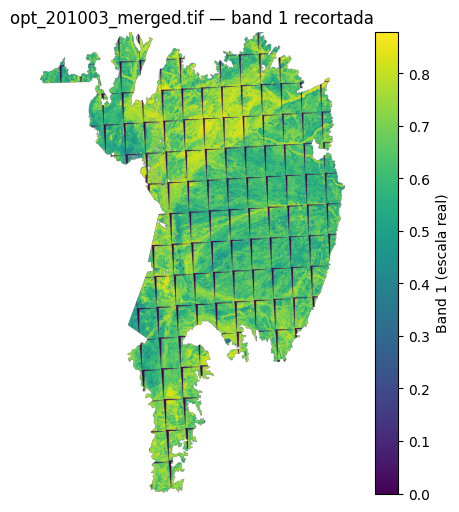

In [ ]:
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask as rio_mask
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# === entradas ===
tif_fp = "/content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_201003_merged.tif"  # <- troque
boundary_fp = CONFIG["boundary_path"]  # seu shapefile do Pantanal
band_idx = 1  # 1=NDVI, 2=EVI, 3=NBR, 4=MNDWI, 5=dNBR, 6=RdNBR, 7=OBS

# === recorte ===
pant = gpd.read_file(boundary_fp)
with rio.open(tif_fp) as src:
    # reprojeta o polígono pro CRS do raster
    pant_r = pant.to_crs(src.crs)
    geom = [g.__geo_interface__ for g in pant_r.geometry]
    out, out_transform = rio_mask(src, geom, crop=True, nodata=src.nodata)
    nod = src.nodata
    profile = src.profile

arr = out[band_idx-1].astype(float)
if nod is not None:
    arr = np.where(arr==nod, np.nan, arr)

# === plot ===
plt.figure(figsize=(8,6))
# faixa “legal” pra NDVI/EVI/NBR/MNDWI (int16 → /10000)
if band_idx in (1,2,3,4):
    plt.imshow(arr/10000.0, cmap="viridis")
    plt.colorbar(label=f"Band {band_idx} (escala real)")
else:
    plt.imshow(arr, cmap="viridis")
    plt.colorbar(label=f"Band {band_idx}")

plt.title(f"{Path(tif_fp).name} — band {band_idx} recortada")
plt.axis("off")
plt.show()



In [7]:
# @title Célula 6.QC — QC leve dos exports 300 m (série completa + arquivos mesclados)
import re, glob, json, math
from pathlib import Path
import numpy as np
import rasterio as rio
from tqdm.auto import tqdm
import pandas as pd

OPT_FOLDER = CONFIG["gee_drive_folder_optical"]
WATER_THR  = CONFIG.get("mask_water_threshold", 0.05)
NODATA_I16 = int(CONFIG.get("nodata", -32768))

# ---------- utilidades de path ----------
ROOTS = [Path("/content/drive/MyDrive"), Path("/content/drive/My Drive")]
MERGED_HINTS = ("merged", "mosaic", "mos")  # padrões comuns de mescla

def _glob_all(pattern: str):
    fps = []
    for r in ROOTS:
        fps.extend(glob.glob(str(r / OPT_FOLDER / pattern)))
    return sorted(set(fps))

def _extract_yyyymm(fp: str):
    # tenta capturar 6 dígitos após "opt_"
    m = re.search(r"opt_(\d{6})", Path(fp).name)
    return m.group(1) if m else None

def _find_merged_file(yyyymm: str):
    """
    Heurística:
      1) opt_YYYYMM.tif (sem sufixo de tile) → preferido
      2) qualquer opt_YYYYMM* contendo 'merged'/'mosaic'/'mos'
      3) fallback: maior arquivo dentre opt_YYYYMM*.tif
    Retorna [fp] (lista com um único caminho) ou [] se nada encontrado.
    """
    # 1) exato, sem sufixo
    exact = _glob_all(f"opt_{yyyymm}.tif")
    if exact:
        return [exact[0]]

    # 2) padrões de mescla
    cands = _glob_all(f"opt_{yyyymm}*.tif")
    merged_like = [fp for fp in cands if any(h in Path(fp).stem.lower() for h in MERGED_HINTS)]
    if merged_like:
        # se houver mais de um, escolhe o maior (em bytes)
        merged_like.sort(key=lambda p: Path(p).stat().st_size, reverse=True)
        return [merged_like[0]]

    # 3) fallback: maior entre todos os opt_YYYYMM*.tif
    if cands:
        cands.sort(key=lambda p: Path(p).stat().st_size, reverse=True)
        return [cands[0]]

    return []

def _list_month_files_merged_first(yyyymm: str):
    return _find_merged_file(yyyymm)

# ---------- leitura por blocos ----------
def _iter_valid_block(src, window):
    nd = src.nodata
    b1 = src.read(1, window=window).astype(np.int16)  # NDVI
    b2 = src.read(2, window=window).astype(np.int16)  # EVI
    b3 = src.read(3, window=window).astype(np.int16)  # NBR
    b4 = src.read(4, window=window).astype(np.int16)  # MNDWI
    b5 = src.read(5, window=window).astype(np.int16) if src.count >= 5 else None  # dNBR
    b6 = src.read(6, window=window).astype(np.int16) if src.count >= 6 else None  # RdNBR
    b7 = src.read(7, window=window).astype(np.int16) if src.count >= 7 else None  # OBS

    valid = (b1!=nd)&(b2!=nd)&(b3!=nd)&(b4!=nd)
    if b7 is not None:
        valid &= (b7!=nd)&(b7>=1)
    if not np.any(valid):
        return None

    ndvi  = (b1[valid].astype(np.float32))/10000.0
    evi   = (b2[valid].astype(np.float32))/10000.0
    nbr   = (b3[valid].astype(np.float32))/10000.0
    mndwi = (b4[valid].astype(np.float32))/10000.0

    # dNBR / RdNBR podem ter NoData próprios; filtra antes de escalar
    if b5 is not None:
        dmask = (b5[valid] != nd)
        dnbr  = (b5[valid][dmask].astype(np.float32))/10000.0
    else:
        dnbr = None
    if b6 is not None:
        rmask = (b6[valid] != nd)
        rdnbr = (b6[valid][rmask].astype(np.float32))/10000.0
    else:
        rdnbr = None

    obs = (b7[valid].astype(np.float32)) if b7 is not None else None
    return ndvi, evi, nbr, mndwi, dnbr, rdnbr, obs, valid.sum(), b1.size

def qc_one_month(yyyymm, target_samples=150_000, seed=123):
    fps = _list_month_files_merged_first(yyyymm)
    if not fps:
        return {"yyyymm": yyyymm, "n_files": 0, "note": "sem_arquivos"}

    rng = np.random.default_rng(seed)
    total_valid = 0
    total_px    = 0
    crs_set, res_set, nod_set, band_set = set(), set(), set(), set()

    for fp in fps:
        with rio.open(fp) as src:
            crs_set.add(str(src.crs))
            xres, yres = src.res
            res_set.add((float(xres), float(yres)))
            nod_set.add(src.nodata)
            band_set.add(src.count)
            for _, w in src.block_windows(1):
                blk = _iter_valid_block(src, w)
                if blk is None:
                    total_px += w.height * w.width
                    continue
                _, _, _, _, _, _, _, n_valid, n_tot = blk
                total_valid += n_valid
                total_px    += n_tot

    if total_valid == 0:
        return {"yyyymm": yyyymm, "n_files": len(fps), "note": "sem_validos",
                "crs": ";".join(sorted(crs_set)), "res": str(sorted(res_set)),
                "nodata": str(sorted(nod_set)), "bands": str(sorted(band_set))}

    p = min(1.0, target_samples / float(total_valid))

    all_ndvi, all_evi, all_nbr, all_mndwi = [], [], [], []
    all_dnbr, all_rdnbr, all_obs = [], [], []
    wmask_cnt = 0
    valid_cnt = 0
    nd_cnt    = 0

    for fp in fps:
        with rio.open(fp) as src:
            nd = src.nodata
            for _, w in src.block_windows(1):
                blk = _iter_valid_block(src, w)
                if blk is None:
                    nd_cnt += w.height * w.width
                    continue

                ndvi, evi, nbr, mndwi, dnbr, rdnbr, obs, n_valid, _ = blk
                valid_cnt += n_valid
                wmask_cnt += np.count_nonzero(mndwi > WATER_THR)

                # subamostragem
                n = ndvi.size
                k = int(np.round(p * n))
                if k > 0:
                    idx = rng.choice(n, size=min(k, n), replace=False)
                    all_ndvi.append(ndvi[idx])
                    all_evi.append(evi[idx])
                    all_nbr.append(nbr[idx])
                    all_mndwi.append(mndwi[idx])
                    if obs is not None and obs.size == n:
                        all_obs.append(obs[idx])

                if dnbr is not None and dnbr.size > 0:
                    k2 = int(np.round(p * dnbr.size))
                    if k2 > 0:
                        idx2 = rng.choice(dnbr.size, size=min(k2, dnbr.size), replace=False)
                        all_dnbr.append(dnbr[idx2])

                if rdnbr is not None and rdnbr.size > 0:
                    k3 = int(np.round(p * rdnbr.size))
                    if k3 > 0:
                        idx3 = rng.choice(rdnbr.size, size=min(k3, rdnbr.size), replace=False)
                        all_rdnbr.append(rdnbr[idx3])

    def _stats(arrs, name):
        if not arrs:
            return {f"{name}_p1": np.nan, f"{name}_p50": np.nan, f"{name}_p99": np.nan,
                    f"{name}_pct_zero": np.nan, f"{name}_n": 0}
        v = np.concatenate(arrs)
        if v.size == 0:
            return {f"{name}_p1": np.nan, f"{name}_p50": np.nan, f"{name}_p99": np.nan,
                    f"{name}_pct_zero": np.nan, f"{name}_n": 0}
        p1, p50, p99 = np.nanpercentile(v, [1, 50, 99])
        pct0 = 100 * np.mean(np.isclose(v, 0.0, atol=1e-6))
        return {f"{name}_p1": float(p1), f"{name}_p50": float(p50), f"{name}_p99": float(p99),
                f"{name}_pct_zero": float(pct0), f"{name}_n": int(v.size)}

    rec = {"yyyymm": yyyymm, "n_files": len(fps),
           "crs": ";".join(sorted(crs_set)),
           "res": str(sorted(res_set)),
           "nodata": str(sorted(nod_set)),
           "bands": str(sorted(band_set))}

    rec.update(_stats(all_ndvi, "NDVI"))
    rec.update(_stats(all_evi,  "EVI"))
    rec.update(_stats(all_nbr,  "NBR"))
    rec.update(_stats(all_mndwi,"MNDWI"))

    if all_dnbr:
        v = np.concatenate(all_dnbr)
        rec.update(_stats([v], "dNBR"))
        rec["dNBR_p95"] = float(np.nanpercentile(v, 95))
    else:
        rec.update({k: np.nan for k in ["dNBR_p1","dNBR_p50","dNBR_p99","dNBR_pct_zero","dNBR_n","dNBR_p95"]})

    if all_rdnbr:
        v = np.concatenate(all_rdnbr)
        rec.update(_stats([v], "RdNBR"))
    else:
        rec.update({k: np.nan for k in ["RdNBR_p1","RdNBR_p50","RdNBR_p99","RdNBR_pct_zero","RdNBR_n"]})

    if all_obs:
        o = np.concatenate(all_obs)
        rec.update({
            "OBS_min": float(np.nanmin(o)),
            "OBS_med": float(np.nanmedian(o)),
            "OBS_max": float(np.nanmax(o)),
            "OBS_n":   int(o.size)
        })
    else:
        rec.update({"OBS_min": np.nan, "OBS_med": np.nan, "OBS_max": np.nan, "OBS_n": 0})

    rec["pct_water_high_among_valid"] = 100.0 * (wmask_cnt / max(1, valid_cnt))
    rec["approx_pct_nodata_any"]     = 100.0 * (nd_cnt    / max(1, valid_cnt + nd_cnt))

    return rec

# ---------- descobrir automaticamente todos os YYYYMM disponíveis ----------
all_files = _glob_all("opt_*.tif")
all_ym = sorted({_extract_yyyymm(fp) for fp in all_files if _extract_yyyymm(fp)})
print(f"Meses detectados na pasta (serie completa): {len(all_ym)}")
print("Exemplos:", all_ym[:5], "…", all_ym[-5:])

# (Opcional) Filtrar por intervalo:
# all_ym = [ym for ym in all_ym if ym >= "198701" and ym <= "202112"]

# ---------- rodar QC ----------
rows=[]
for ym in tqdm(all_ym, desc="QC 300m — meses (arquivos mesclados)"):
    rows.append(qc_one_month(ym, target_samples=150_000, seed=123))

df = pd.DataFrame(rows).sort_values("yyyymm")
display_cols = [
    "yyyymm","n_files","approx_pct_nodata_any","pct_water_high_among_valid",
    "NDVI_p1","NDVI_p50","NDVI_p99",
    "EVI_p1","EVI_p50","EVI_p99",
    "NBR_p1","NBR_p50","NBR_p99",
    "MNDWI_p1","MNDWI_p50","MNDWI_p99",
    "dNBR_p50","dNBR_p95","RdNBR_p50",
    "OBS_min","OBS_med","OBS_max"
]
print("— Resumo (amostra) —")
print(df[display_cols].head(10).to_string(index=False))

qc_csv = OUT_DIR / "qc_optical_300m_summary.csv"
df.to_csv(qc_csv, index=False)
print("✔ QC salvo em:", qc_csv)



Meses detectados na pasta (serie completa): 197
Exemplos: ['198509', '198603', '198607', '198609', '198611'] … ['202103', '202105', '202107', '202109', '202111']


QC 300m — meses (arquivos mesclados):   0%|          | 0/197 [00:00<?, ?it/s]

— Resumo (amostra) —
yyyymm  n_files  approx_pct_nodata_any  pct_water_high_among_valid  NDVI_p1  NDVI_p50  NDVI_p99   EVI_p1  EVI_p50  EVI_p99    NBR_p1  NBR_p50  NBR_p99  MNDWI_p1  MNDWI_p50  MNDWI_p99  dNBR_p50  dNBR_p95  RdNBR_p50  OBS_min  OBS_med  OBS_max
198509        1              41.957689                         0.0   0.2318    0.4732  0.790500 0.141500   0.2922 0.556601 -0.071700   0.3194 0.718200   -0.5773    -0.4498  -0.021099    0.0735    0.2750     0.1221      1.0      2.0      8.0
198603        1              41.091803                         0.0   0.4492    0.6336  0.811500 0.153000   0.3415 0.531200  0.216400   0.5522 0.765000   -0.5941    -0.4825  -0.034700    0.0167    0.1001     0.0216      1.0      5.0     19.0
198607        1              41.188805                         0.0   0.2819    0.5106  0.741900 0.125100   0.2799 0.489200 -0.080300   0.3426 0.729000   -0.5949    -0.5014  -0.061200    0.1480    0.3280     0.2145      1.0      2.0     10.0
198609        1

In [ ]:

# @title Célula 6 — Export VOD (SMAP vod_pm) separado, com barra de progresso

import json, time
from tqdm.notebook import tqdm

if not CONFIG.get("use_smap_vod", True):
    print("VOD está desativado em CONFIG['use_smap_vod']=False.")
else:
    VOD_FOLDER = CONFIG["gee_drive_folder_vod"]
    all_slices_vod = get_time_slices(CONFIG["years"], CONFIG["calendar"])
    print("Total de períodos (VOD):", len(all_slices_vod))

    # checkpoint VOD
    CKP_VOD = LOG_DIR / "export_vod_checkpoint.json"
    vod_state = json.load(open(CKP_VOD)) if CKP_VOD.exists() else {"done": {}}

    smap = ee.ImageCollection(CONFIG["ee_assets"]["smap_vod"]).select('vod_pm')

    pending_vod = []
    for yyyymm in all_slices_vod:
        if vod_state["done"].get(yyyymm) and CONFIG["resume"]:
            continue

        start, end = period_for_yyyymm(yyyymm)
        mean = smap.filterDate(start, end).mean().set({'yyyymm': yyyymm})

        task = ee.batch.Export.image.toDrive(
            image = mean.toFloat(),
            description = f"vod_{yyyymm}",
            folder = VOD_FOLDER,
            fileNamePrefix = f"vod_{yyyymm}",
            region = pant_simpl,
            crs = f"EPSG:{CONFIG['crs_epsg']}",
            scale = 10000,
            maxPixels = 1e13,
            fileFormat = 'GeoTIFF',
            formatOptions = {'noData': -9999}
        )
        task.start()
        pending_vod.append((yyyymm, task))

    print(f"Tasks lançadas (VOD): {len(pending_vod)}")

    # barra de progresso VOD
    completed = 0
    with tqdm(total=len(pending_vod), desc="VOD — períodos concluídos") as pbar:
        last_states = {}
        while completed < len(pending_vod):
            newly_done = 0
            for yyyymm, t in pending_vod:
                st = t.status()
                state = st.get('state', 'UNKNOWN')
                if last_states.get(t.id) != state:
                    log(f"[VOD {yyyymm}] {state}")
                    last_states[t.id] = state
                if state == "COMPLETED" and not vod_state["done"].get(yyyymm):
                    vod_state["done"][yyyymm] = True
                    newly_done += 1
            if newly_done:
                completed += newly_done
                pbar.update(newly_done)
                json.dump(vod_state, open(CKP_VOD, "w"))
            if completed < len(pending_vod):
                time.sleep(10)

    print(f"✔ VOD finalizado: {completed}/{len(pending_vod)} períodos concluídos.")
    print(f"✔ Checkpoint salvo em: {CKP_VOD}")







[198601] NDVI amostrado (275 px @ 240 m): p1=0.4155  p50=0.6534  p99=0.8337  %zeros=0.00%
OBS — min/med/max: 1 2.0 12
Amostras prontas para reuso (lon/lat) → SAMPLE_POINTS.shape: (275, 2)
